<div class="alert alert-block alert-info">
    <h2><center>Estimación de la desviación de precios del sistema eléctrico chileno</center></h2>
    <center>Descripción: Estimación de la desviación de los costos marginales en distintos nodos del sistema, entendiendo qué variables son las que más afectan su comportamiento y cómo esto podría ser útil para la eficiencia del sistema.</center>
</div>

In [1]:
###
# Bibliotecas
###
#Manejo de datos
import pandas as pd
#Librerias cientificas
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_text
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Input
#Computo matricial y númerico
import numpy as np
#Visualizacion
import graphviz 
import plotly
import plotly.graph_objects as go
import plotly.express as px
#Utilidades
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam
import pydot

Using TensorFlow backend.


# Contexto

## Desafío
En este desafío estimaremos la desviación de precios del sistema eléctrico chileno. Específicamente, estimaremos la desviación de los costos marginales en distintos nodos del sistema, entendiendo qué variables son las que más afectan su comportamiento y cómo esto podría ser útil para la eficiencia del sistema. Para ello, hemos construido un dataset usando datos públicos y reales del sistema eléctrico de Chile.

Algunas definiciones importantes:

**Sistema Eléctrico**: Conjunto de instalaciones de centrales eléctricas generadoras, líneas de transporte, subestaciones eléctricas, líneas de distribución, interconectadas entre sí, que permite generar, transportar y distribuir energía eléctrica.

**Subestación**: Conjunto de instalaciones eléctricas (transformadores, aisladores, interruptores, etc) y de infraestructura (terreno, edificio, etc), que sirven para transferir energía, transformar voltajes, recibir y entregar energía y suministrar electricidad a consumos.

**Barra Principal**: Es un tramo de conductores aislados, donde convergen líneas de transmisión, alimentación a bancos de autotransformadores y transformadores de poder que retiran o inyectan energía a la barra, permitiendo el traspaso de flujos de potencias entre las líneas. Si tienes dudas, puedes consultar el glosario del SIC (Sistema Interconectado Central) en https://sic.coordinador.cl/wp-content/uploads/2013/12/MP_Glosario_CDEC-SIC.pdf

- Nivel de observación: día-hora y subestación (cada fila es una subestación y día-hora).

    - nemotecnico_se: código subestación eléctrica

    - fecha, hora: año, mes, día y hora.

    - gen_eolica_total_mwh: generación eólica total por subestación en MWh

    - gen_geotermica_total_mwh: generación geotérmica total por subestación en MWh

    - gen_hidraulica_total_mwh: generación hidráulica total por subestación en MWh

    - gen_solar_total_mwh: generación solar total por subestación en MWh

    - gen_termica_total_mwh: generación térmica total por subestación en MWh

    - cmg_real: costo marginal real [USD/MWh] promedio por subestación

    - cmg_prog: costo marginal programado [USD/MWh] promedio por subestación

    - cmg_desv: desviación absoluta promedio entre costo marginal programado y costo marginal real

    - cmg_desv_pct: desviación porcentual promedio del costo marginal real con respecto al costo marginal programado

    - n_barras: número de barras conectadas aguas abajo de una subestación

    - demanda_mwh: retiros de energía [MWh] efectuados por compañías coordinadas bajo el sistema eléctrico

    - cap_inst_mw: capacidad de generación máxima instalada por subestación [MW]

## Carga de los datos

Instrucciones:

- Carga el archivo costo_marginal_real.csv. Estos son los costos marginales reales observados.
- Carga el archivo costo_marginal_programado.csv. Estos son los costos marginales previstos por el sistema.

In [2]:
#Cargar archivos como variables privadas
_costo_marginal_programado_df = pd.read_csv (r'./Datasets/costo_marginal_programado.csv')
_base_prediccion_df = pd.read_csv (r'./Datasets/base_para_prediccion.csv')
_costo_marginal_real_df = pd.read_csv(r'./Datasets/costo_marginal_real.csv')
_demanda_real_df = pd.read_csv(r'./Datasets/demanda_real.csv')
_datos_clima_df = pd.read_csv(r'./Datasets/datos_clima.csv')

## Análisis de los datos

In [3]:
#Buscar valores missing
print('Costo marginal programado total:{} \n Valores NAN: \n{}'.format(len(_costo_marginal_programado_df),_costo_marginal_programado_df.isnull().sum()))
print('\nCosto marginal real total:{} \n Valores NAN: \n {}'.format(len(_costo_marginal_real_df),_costo_marginal_real_df.isnull().sum()))
print('\nBase para predicción: {} \n Valores NAN: \n{}'.format(len(_base_prediccion_df),_base_prediccion_df.isnull().sum()))
#print('\nDemanda real: {} \n Valores NAN: \n {}'.format(len(_demanda_real_df),_demanda_real_df.isnull().sum()))
print('\nDatos de clima: {} \n Valores NAN: \n{}'.format(len(_datos_clima_df),_datos_clima_df.isnull().sum()))


Costo marginal programado total:1192124 
 Valores NAN: 
mnemotecnico_barra    0
nombre_barra          0
fecha                 0
hora                  0
costo                 0
dtype: int64

Costo marginal real total:4309951 
 Valores NAN: 
 barra_mnemotecnico               0
barra_referencia_mnemotecnico    0
fecha                            0
hora                             0
costo_en_dolares                 0
costo_en_pesos                   0
nombre                           0
dtype: int64

Base para predicción: 112779 
 Valores NAN: 
nemotecnico_se                   0
fecha                            0
hora                             0
gen_eolica_total_mwh        112779
gen_geotermica_total_mwh    112779
gen_hidraulica_total_mwh     78595
gen_solar_total_mwh          70961
gen_termica_total_mwh        50916
cmg_real                         0
cmg_prog                         0
cmg_desv                         0
cmg_desv_pct                     0
n_barras                         0


In [4]:
#Análisis de los ID's
#Analisis de la distribución de barras agrupados por su nombre

#Tabla del costo marginal programado
_costo_marginal_programado_df.\
groupby(['mnemotecnico_barra'])['mnemotecnico_barra'].\
count().\
reset_index(name='Contador_Unicos').\
sort_values(by='Contador_Unicos',ascending=False)

,mnemotecnico_barra,Contador_Unicos
0,-,180115
66,BA01T002SE036T002,8690
114,BA02T003SE004T003,8690
225,BA83L131SE134L131,7538
134,BA03T002SE026T002,4345
...,...,...
203,BA47T005SE021G216,3769
173,BA22L120SE079L120,3769
205,BA51G226SE091G226,3769
206,BA52G216SE023G216,3769


In [5]:
#Tabla del costo marginal real agrupando sus elementos por su nombre
_costo_marginal_real_df.\
groupby(['barra_mnemotecnico'])['barra_mnemotecnico'].\
count().\
reset_index(name='Contador_Unicos').\
sort_values(by='Contador_Unicos',ascending=False)

,barra_mnemotecnico,Contador_Unicos
0,BA01G004SE001T011,4345
644,BA02T005SE185T005,4345
646,BA02T005SE188T005,4345
647,BA02T005SE189T005,4345
648,BA02T005SE190T005,4345
...,...,...
927,BA42G216SE187G216,1464
999,BA87T005SE275T005,744
971,BA65T005SE277T005,744
957,BA56T005SE276T005,744


In [6]:
_datos_clima_df.\
groupby(['subestacion'])['subestacion'].\
count().\
reset_index(name='Contador_Unicos').\
sort_values(by='Contador_Unicos',ascending=False)

,subestacion,Contador_Unicos
0,SE001T002,181
15,SE031G216,181
27,SE127T005,181
26,SE123G216,181
25,SE106G216,181
24,SE103L123,181
23,SE082T005,181
22,SE081T005,181
21,SE071T005,181
20,SE067T005,181


<div class="alert alert-block alert-warning">
    <h3><center>Observaciones</center></h3>
    <p align="right"/>
        <ul style="list-style-type:square">
        <li> Se puede observar que hay valores nan en la tabla de 'Base para predicción', además 2 de las columnas son solo valores nan.</li>
        <li> Además, en la tabla de costos marginales programados se observa un caracter '-' que simplemente genera ruido en la tabla, por lo que habrá que eliminarlos</li>
        <li>La tabla de costos marginales parece ser mas homogenea, puesto que no se observan valores nan ni tampoco hay valores 'missing' en sus id's</li>
        <li>Para la tabla de datos del clima tampoco se observaron valores nan y la distribución de las subestaciones es perfectamente homogenea
        </ul>

</div>


In [7]:
#Borrar filas con valores missing '-' en la tabla de costos marginales programados
print('Total de filas antes de eliminar missings: {}'.format(len(_costo_marginal_programado_df)))
_costo_marginal_prog_clean = _costo_marginal_programado_df.drop(_costo_marginal_programado_df[_costo_marginal_programado_df['mnemotecnico_barra']=='-'].index)
print('Total de filas después de eliminar missings: {}'.format(len(_costo_marginal_prog_clean)))


Total de filas antes de eliminar missings: 1192124
Total de filas después de eliminar missings: 1012009


In [8]:
#Busqueda de duplicados

_costo_marginal_prog_clean = _costo_marginal_prog_clean.drop_duplicates(subset=['mnemotecnico_barra', 'fecha','hora'])
_costo_marginal_real_df = _costo_marginal_real_df.drop_duplicates(subset=['barra_mnemotecnico', 'fecha','hora'])

print('Total de filas después de eliminar duplicados en costos marginales programdos: {}'.format(len(_costo_marginal_prog_clean)))
print('Total de filas después de eliminar duplicados en costos marginales reales: {} NO HAY DUPLICADOS EN ESTA TABLA'.format(len(_costo_marginal_real_df)))



Total de filas después de eliminar duplicados en costos marginales programdos: 999550
Total de filas después de eliminar duplicados en costos marginales reales: 4309951 NO HAY DUPLICADOS EN ESTA TABLA


### 1. Costos Marginales

Instrucciones:

Haz un merge del costos marginal real con el costo marginal programado a nivel de barra (*Ayuda: la columna de join no se llama igual en ambas bases! Los datos venían así del SIC *). Llama a esta nueva base costo_marginal

In [9]:
_costo_marginal_prog_clean.tail()

,mnemotecnico_barra,nombre_barra,fecha,hora,costo
1192095,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,20,52.319394
1192096,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,21,53.165387
1192097,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,22,53.219271
1192098,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,23,52.936222
1192099,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,24,51.328911


In [10]:
#Se observa una hora 25
_costo_marginal_real_df.head()

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_en_dolares,costo_en_pesos,nombre
0,BA01T005SE075T005,BA02T002SE032T002,2019-04-06,25,62.24,41.47176,BA S/E LORETO 15KV
1,BA01T005SE175T005,BA02T002SE032T002,2019-04-06,25,62.56,41.68498,BA S/E RETIRO 13.2KV
2,BA03R002SE002R002,BA02T002SE032T002,2019-04-06,25,60.04,40.00585,BA S/E ALTAMIRANO 12.5KV BP1
3,BA01R002SE012R002,BA02T002SE032T002,2019-04-06,25,61.65,41.07863,BA S/E CURACAVI 44KV B1
4,BA03R002SE013R002,BA02T002SE032T002,2019-04-06,25,59.55,39.67936,BA S/E EL MANZANO (ENEL DISTRIBUCIÓN) 23KV BP1


In [11]:
_costo_marginal_real_df.\
groupby(['hora'])['hora'].\
count().\
reset_index(name='Contador_Unicos').\
sort_values(by='Contador_Unicos')

,hora,Contador_Unicos
24,25,991
22,23,179540
21,22,179540
20,21,179540
19,20,179540
18,19,179540
17,18,179540
16,17,179540
15,16,179540
14,15,179540


La hora 25 parece ser un dato anómalo y no agrega información relevante, además es el único dato desvalanceado de la tabla

In [12]:
#Eliminar dato de hora 25
_costo_marginal_real_clean = _costo_marginal_real_df.drop(_costo_marginal_real_df\
                                                                [_costo_marginal_real_df\
                                                                 ['hora']==25].index)
print('Tabla de costo marginal antes de elimnar la hora 25: {}\n'\
     'Tabla de costo marginal después de elimnar la hora 25: {}'.format(len(_costo_marginal_real_df),len(_costo_marginal_real_clean)))


Tabla de costo marginal antes de elimnar la hora 25: 4309951
Tabla de costo marginal después de elimnar la hora 25: 4308960


<div class="alert alert-block alert-warning">
    <h3><center>Observaciones</center></h3>
    <p align="right"/>
        <ul style="list-style-type:square">
        <li> Hay 1020 barras en reales en total y solo hay 238 barras en la tabla de costo marginal programado</li>
        <li> A partir de aquí se tiene que averiguar si las 238 barras que estan programadas también aparecen en la tabla de las barras de los costos marginales reales, es decir, las barras programadas deben ser un subconjunto de las reales</li>
        <li>Se debe cambiar los nombres de los Id's (columna: mnemotecnico_barra) en la tabla costo marginal programado para hacer coincidir el nombre de las barras con la tabla de costos marginal real así poder hacer la mezcla</li>
        <li>Por último se deben elegir los atributos de tabla mas relevantes para el análisis</li>
        </ul>

</div>




In [13]:
#Cambiar nombre de la llave para hacer coincidir en la indexación
_costo_marginal_prog_clean = _costo_marginal_prog_clean.rename(columns = {'mnemotecnico_barra':'barra_mnemotecnico'})

#Descomponer la tabla de costo_marginal_real y costo_marginal_prog_clean para elegir los atributos mas relevantes
_costo_marginal_real_ = _costo_marginal_real_clean[['barra_mnemotecnico','fecha','hora','costo_en_pesos']]
#Cambiar el nombre del costo
_costo_marginal_real_ = _costo_marginal_real_.rename(columns = {'costo_en_pesos':'costo_real'})

_costo_marginal_prog_ = _costo_marginal_prog_clean[['barra_mnemotecnico','fecha','hora','costo']]
_costo_marginal_prog_ = _costo_marginal_prog_.rename(columns = {'costo':'costo_programado'})

print(_costo_marginal_prog_.columns)
print(_costo_marginal_real_.columns)


Index(['barra_mnemotecnico', 'fecha', 'hora', 'costo_programado'], dtype='object')
Index(['barra_mnemotecnico', 'fecha', 'hora', 'costo_real'], dtype='object')


<div class="alert alert-block alert-warning">
 <p align="right"/>
    Para saber si todas las barras programadas estan en la tabla de barras reales voy a cruzar las tablas a partir del nombre de la tabla, esto se hará convirtiendo la columna 'barra_mnemotecnico' de la tabla _costos_marginales_programados en una lista y realizar una busqueda de los elementos de esa lista en la tabla de _costos_marginales_reales
</div> 

In [14]:
#Extraer lista de barras
lista_barra_prog = _costo_marginal_prog_.barra_mnemotecnico.to_list()

lista_barra_prog

['BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA01T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002SE002T002',
 'BA03T002

In [15]:
_costo_marginal_real_.\
groupby(['barra_mnemotecnico'])['barra_mnemotecnico'].\
count().\
reset_index(name='Contador_Unicos').\
sort_values(by='Contador_Unicos',ascending=False)

,barra_mnemotecnico,Contador_Unicos
0,BA01G004SE001T011,4344
644,BA02T005SE185T005,4344
646,BA02T005SE188T005,4344
647,BA02T005SE189T005,4344
648,BA02T005SE190T005,4344
...,...,...
927,BA42G216SE187G216,1464
999,BA87T005SE275T005,744
971,BA65T005SE277T005,744
957,BA56T005SE276T005,744


In [16]:
#Buscar en la tabla _costo_marginal_real_ las barras que coinciden con 
#la lista de barras de la tabla de costo_marginal_programado
coincidencias_real = _costo_marginal_real_.loc[
    _costo_marginal_real_.barra_mnemotecnico.isin(lista_barra_prog),:]
coincidencias_real

,barra_mnemotecnico,fecha,hora,costo_real
992,BA02T005SE081T005,2019-01-24,1,42.16415
998,BA01R002SE041R002,2019-01-24,1,36.86002
1003,BA01G132SE001G132,2019-01-24,1,36.83985
1005,BA56G216SE023G216,2019-01-24,1,40.41627
1006,BA68T005SE277T005,2019-01-24,1,40.55072
...,...,...,...,...
4309928,BA05T005SE288T005,2019-01-23,24,42.79953
4309931,BA01L081SE066L081,2019-01-23,24,49.20770
4309936,BA04T005SE071T005,2019-01-23,24,45.18662
4309945,BA01L079SE004L079,2019-01-23,24,52.18652


In [17]:
#Tamaño de las tablas después de aplicar los cambios
print(coincidencias_real.shape,_costo_marginal_prog_.shape)

(929520, 4) (999550, 4)


In [62]:
#Mezcla de los datos
costo_marginal = pd.merge(
    _costo_marginal_prog_, #izquierda
    coincidencias_real, #derecha
    on=['barra_mnemotecnico','fecha','hora'], #atributo de union
    how='inner'
)
costo_marginal

,barra_mnemotecnico,fecha,hora,costo_programado,costo_real
0,BA01T002SE002T002,2019-01-01,1,49.897334,34.89581
1,BA01T002SE002T002,2019-01-01,2,50.471616,34.89581
2,BA01T002SE002T002,2019-01-01,3,50.077821,34.19316
3,BA01T002SE002T002,2019-01-01,4,49.796216,33.61574
4,BA01T002SE002T002,2019-01-01,5,49.796216,32.19653
...,...,...,...,...,...
900715,BA83L131SE134L131,2019-06-06,20,52.319394,34.18403
900716,BA83L131SE134L131,2019-06-06,21,53.165387,34.18403
900717,BA83L131SE134L131,2019-06-06,22,53.219271,34.18403
900718,BA83L131SE134L131,2019-06-06,23,52.936222,32.18427


In [19]:
costo_marginal.\
groupby(['barra_mnemotecnico'])['barra_mnemotecnico'].\
count().\
reset_index(name='Contador_Unicos').\
sort_values(by='Contador_Unicos',ascending=False)

,barra_mnemotecnico,Contador_Unicos
0,BA01G004SE001T011,4344
121,BA03T002SE026T002,4344
113,BA03G010SE001G010,4344
114,BA03G010SE054G010,4344
115,BA03G011SE001G011,4344
...,...,...
81,BA01T005SE284T005,2160
3,BA01G004SE035G004,2160
90,BA01T038SE001G130,2160
173,BA38T005SE282T005,2160


In [63]:
costo_marginal.describe()


,hora,costo_programado,costo_real
count,900720.00000,900720.000000,900720.000000
mean,12.50000,61.911869,39.509093
std,6.92219,23.872680,15.590217
min,1.00000,-12.113677,0.000000
25%,6.75000,49.979576,32.552700
50%,12.50000,55.064828,35.965350
75%,18.25000,64.208912,41.253620
max,24.00000,610.600000,523.418220


In [59]:
_costo_marginal_real_.describe()

,hora,costo_real
count,4.308960e+06,4.308960e+06
mean,1.250000e+01,4.300023e+01
std,6.922187e+00,1.865194e+01
min,1.000000e+00,0.000000e+00
25%,6.750000e+00,3.410603e+01
50%,1.250000e+01,3.799040e+01
75%,1.825000e+01,4.471959e+01
max,2.400000e+01,7.343561e+02


In [61]:
_costo_marginal_prog_.describe()

,hora,costo_programado
count,999550.000000,999550.000000
mean,12.502976,61.983125
std,6.924052,24.013881
min,1.000000,-53.184778
25%,7.000000,50.011312
50%,13.000000,55.139559
75%,19.000000,64.265304
max,25.000000,610.600000


<div class="alert alert-success" role="alert">
    <h2>Análisis</h2>
    <ul style="list-style-type:square">
        <li> Realiza un análisis exploratorio de la base resultante</li>
        <li> ¿Qué puedes decir de las distintas variables?</li>
        <ul>
                <li>No todas las variables sirven para realizar un análisis, en la columna hora, encontre una hora 25, la cual fue borrada.</li>
            <li>Para cruzar las tablas, fue necesario encontrar que el ID (el atributo barra_mnemotecnico) fuera igual en ambas tablas</li>
            <li>También, fue necesario eliminar algunos atributos que no aportaban informacion al análisis, por ejemplo en la tabla de costos marginales reales,el atributo 'barra_referencia_mnemotecnico' era único valor repetido</li>
            <li>La columna de costo en dolares solo aportaba informacion redundante </li>
             <li>Toda información que sea reduntante o que no aporte valor, debe ser eliminada para no causar ruido innecesario al modelo</li>
            </ul>
        <li>¿Cómo se distribuyen? En particular analiza las barras (barra_mnemotecnico). </li>
        <ul>
                <li>En la tabla de costo marginal programado habia un elemento que abarcaba gran cantidad de registros, el simbolo '-', este elemento hace que la información que lo sucede sea irrelevante, por lo que todas esas filas se eliminaron</li>
            <li>Para las barras de costos marginales reales, la distribución es desigual, al hacer el cruce de tablas, la tabla resultante de costo marginal, se volvió mas homogenea, con una desviación estandar de 23.872680 unidades en el costo programado y 15.590217 en el costo real </li>
            <li></li>
            </ul>
        <li>¿Para cuántas barras se programa el costo? </li>
        <ul>
                <li>Se detectó que hay un total de <b>1020</b> barras registradas en el costo marginal real, hay <b>238</b> barras registradas en el costo marginal programado, su vez tenemos que hay <b>220</b> barras que se encuentran en ambos conjuntos, esto quiere decir que de las 1020 barras tan solo se programan 220 dejando de lado 18 barras que son programadas pero no aparecen en la tabla de las barras reales..</li>
            </ul>
        <li>¿Qué porcentaje es del total de barras que puedes observar en la base? </li>
        <ul>
                <li><b>21.5%</b></li>
            </ul>
        </ul>

</div>

## 2. Construcción de variables

Intrucciones:

- Construye las siguientes variables para la base que creaste en el punto anterior:

- **desviación**: la diferencia entre el costo real y el costo programado

- **desviación_pct:** la misma desviación, pero en porcentaje

- **desviacion_cat:** una variable categórica que vale 1si la desviación_pct absoluta es mayor a 15% (esto es, si es menor a -15% o mayor a 15%)

In [21]:
#Se renombran las variables para que sea mas facil la lectura de la tabla
costo_marginal = costo_marginal.rename(columns = {'costo':'costo_programado','costo_en_pesos':'costo_real'})
costo_marginal

,barra_mnemotecnico,fecha,hora,costo_programado,costo_real
0,BA01T002SE002T002,2019-01-01,1,49.897334,34.89581
1,BA01T002SE002T002,2019-01-01,2,50.471616,34.89581
2,BA01T002SE002T002,2019-01-01,3,50.077821,34.19316
3,BA01T002SE002T002,2019-01-01,4,49.796216,33.61574
4,BA01T002SE002T002,2019-01-01,5,49.796216,32.19653
...,...,...,...,...,...
900715,BA83L131SE134L131,2019-06-06,20,52.319394,34.18403
900716,BA83L131SE134L131,2019-06-06,21,53.165387,34.18403
900717,BA83L131SE134L131,2019-06-06,22,53.219271,34.18403
900718,BA83L131SE134L131,2019-06-06,23,52.936222,32.18427


In [22]:
#desviación: la diferencia entre el costo real y el costo programado
costo_marginal['desviacion'] = costo_marginal.costo_real - costo_marginal.costo_programado

costo_marginal.head()

,barra_mnemotecnico,fecha,hora,costo_programado,costo_real,desviacion
0,BA01T002SE002T002,2019-01-01,1,49.897334,34.89581,-15.001524
1,BA01T002SE002T002,2019-01-01,2,50.471616,34.89581,-15.575806
2,BA01T002SE002T002,2019-01-01,3,50.077821,34.19316,-15.884661
3,BA01T002SE002T002,2019-01-01,4,49.796216,33.61574,-16.180476
4,BA01T002SE002T002,2019-01-01,5,49.796216,32.19653,-17.599686


In [23]:
costo_marginal.describe()

,hora,costo_programado,costo_real,desviacion
count,900720.00000,900720.000000,900720.000000,900720.000000
mean,12.50000,61.911869,39.509093,-22.402776
std,6.92219,23.872680,15.590217,21.265817
min,1.00000,-12.113677,0.000000,-579.655670
25%,6.75000,49.979576,32.552700,-23.927670
50%,12.50000,55.064828,35.965350,-18.506356
75%,18.25000,64.208912,41.253620,-15.567303
max,24.00000,610.600000,523.418220,418.980468


In [24]:
#desviación_pct: la misma desviación, pero en porcentaje
costo_marginal['desviacion_pct'] = (costo_marginal.desviacion*100)/(costo_marginal.costo_real)
costo_marginal

,barra_mnemotecnico,fecha,hora,costo_programado,costo_real,desviacion,desviacion_pct
0,BA01T002SE002T002,2019-01-01,1,49.897334,34.89581,-15.001524,-42.989470
1,BA01T002SE002T002,2019-01-01,2,50.471616,34.89581,-15.575806,-44.635176
2,BA01T002SE002T002,2019-01-01,3,50.077821,34.19316,-15.884661,-46.455670
3,BA01T002SE002T002,2019-01-01,4,49.796216,33.61574,-16.180476,-48.133630
4,BA01T002SE002T002,2019-01-01,5,49.796216,32.19653,-17.599686,-54.663300
...,...,...,...,...,...,...,...
900715,BA83L131SE134L131,2019-06-06,20,52.319394,34.18403,-18.135364,-53.052152
900716,BA83L131SE134L131,2019-06-06,21,53.165387,34.18403,-18.981357,-55.526973
900717,BA83L131SE134L131,2019-06-06,22,53.219271,34.18403,-19.035241,-55.684602
900718,BA83L131SE134L131,2019-06-06,23,52.936222,32.18427,-20.751952,-64.478553


In [25]:
#desviacion_cat: una variable categórica que vale 1 
#si la desviación_pct absoluta es mayor a 15% (esto es, si es menor a -15% o mayor a 15%)
costo_marginal['desviacion_cat'] = [1 if abs(porcentaje) > 15 else 0 for porcentaje in costo_marginal.desviacion_pct.to_list()]
costo_marginal.head()

,barra_mnemotecnico,fecha,hora,costo_programado,costo_real,desviacion,desviacion_pct,desviacion_cat
0,BA01T002SE002T002,2019-01-01,1,49.897334,34.89581,-15.001524,-42.989470,1
1,BA01T002SE002T002,2019-01-01,2,50.471616,34.89581,-15.575806,-44.635176,1
2,BA01T002SE002T002,2019-01-01,3,50.077821,34.19316,-15.884661,-46.455670,1
3,BA01T002SE002T002,2019-01-01,4,49.796216,33.61574,-16.180476,-48.133630,1
4,BA01T002SE002T002,2019-01-01,5,49.796216,32.19653,-17.599686,-54.663300,1


Describe la variable desviacion_cat. Qué puedes observar? Cambia a través del tiempo?

In [26]:
#Observar el balanceo de la variable categórica
costo_marginal.groupby(['desviacion_cat'])['desviacion_cat'].count().reset_index(name='Contador')

,desviacion_cat,Contador
0,0,35912
1,1,864808


In [27]:
#Convertir la fecha a un formato reconocible por pandas
costo_marginal.fecha = pd.to_datetime(costo_marginal.fecha,format='%Y-%m-%d')

## 3. Visualización de datos

Intrucciones:

Crea la siguiente función: 

**def time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final):**

que tome como input el código de una barra y haga un plot en el tiempo del costo marginal real y del costo marginal programado. El eje x debe ser el tiempo. fecha_inicial y fecha_final_ dan los límites de este plot. Úsa esta función para plotear algunas barras

In [55]:
#Funcion para graficar 
def time_plot_costo_barra(codigo_barra,fecha_inicial,fecha_final,mostrar_grafica_dinamica=True):
    df_time = costo_marginal.loc[
        (costo_marginal.barra_mnemotecnico == codigo_barra) &
        ((costo_marginal.fecha >= datetime.strptime(fecha_inicial,'%Y-%m-%d'))&
         (costo_marginal.fecha <= datetime.strptime(fecha_final,'%Y-%m-%d'))) &
        (costo_marginal.costo_real > 0),
        ['barra_mnemotecnico','fecha','hora','costo_real','costo_programado']
    ].sort_values(by = ['fecha','hora'])
    
    fig = px.line(df_time,x = 'fecha',y = 'costo_real',title = 'fechas_real')
    #fig = px.line(df_time,x = 'fecha',y = 'costo_programado',title = 'fechas_prog')
    if mostrar_grafica_dinamica: fig.show()
    fig.show("png")#Se construyó en png para que no haya problemas al exportar a github
    
    return df_time

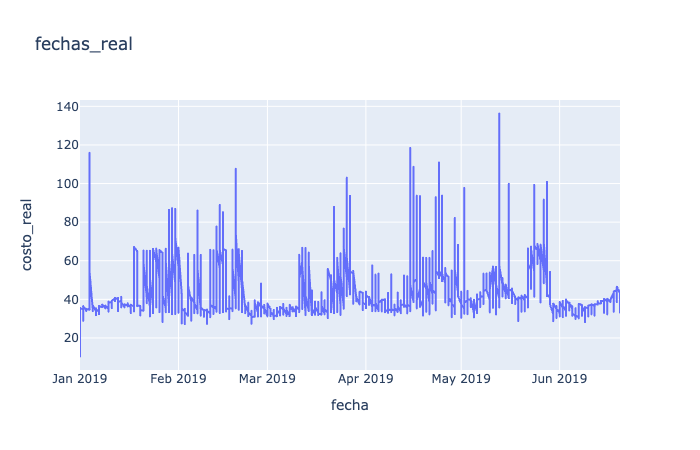

,hora,costo_real,costo_programado
count,4104.00000,4104.000000,4104.000000
mean,12.50000,43.664516,61.127861
std,6.92303,14.129571,14.297788
min,1.00000,10.386650,40.504135
25%,6.75000,35.175530,52.439992
50%,12.50000,38.219960,55.977760
75%,18.25000,46.022250,63.586729
max,24.00000,136.290680,155.448133


In [56]:
time = time_plot_costo_barra('BA01T002SE002T002','2019-01-01','2019-06-20')
time.describe()

<div class="alert alert-success" role="alert">
    <h2>Análisis</h2>
     <p align="right"/>
    Qué puedes concluir de estos plots?
   
</div>

## 4. Base para los modelos
4. Base para los modelos
Carga la base base_para_predicción.csv. Esta será la base principal para las siguientes preguntas.

En rasgos generales, ¿Qué puedes decir de los datos? (dimensiones, tipo de datos, variables categóricas, variables numéricas, fechas).

A partir de la variable fecha, crea nuevas variables para el año, mes, semana del año, dia del calendario, dia de la semana y una variable que indique si el dia corresponde a un día de semana o fin de semana. Estas features/variables te servirán para entrenar el modelo.
Implementa una función que para una subestación y una variable, grafique múltiples series de tiempo diarias correspondientes a una lista de fechas. Para esto, la función debe recibir como argumentos: código de una subestación, una variable (serie numérica), y una lista de fechas (año-mes-día). Por ejemplo: para la subestación SE005T002 y la variable gen_solar_total_mwh, la función debe graficar los perfiles diarios de generación solar por hora para las fechas '2019-01-10', '2019-02-10' y '2019-03-10'.
Grafica la curva de generación solar, por hora, en la subestación SE005T002 para las fechas del 10, 11, 12, 13 y 14 de enero de 2019. Haz lo mismo para la subestación SE127T005. Que podrías decir, en términos generales, sobre la generación solar y las dos subestaciones mencionadas, basados en estos dos gráficos?
Grafica la curva de generación térmica, por hora, en la subestación SE020G213 para los días 14, 15, 16 y 17 de mayo de 2019. Haz lo mismo para la subestación SE106G216. Que podrías decir, en términos generales, sobre la generación térmica en esta subestación con respecto a este gráfico?

In [30]:
_base_prediccion_df.describe()

,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
count,112779.000000,0.0,0.0,34184.000000,41818.000000,61863.000000,112779.000000,112779.000000,112779.000000,112779.00,112779.000000,1.127790e+05,112779.000000
mean,12.502993,NaN,NaN,38.120053,3.764987,40.583146,61.170058,62.215400,-1.045338,inf,2.331844,6.357056e+07,128.719565
std,6.924090,NaN,NaN,69.838109,12.904388,101.083396,25.414147,25.307759,24.711575,NaN,1.304096,3.948683e+08,167.948649
min,1.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-1.713131,-562.470000,-3403.97,1.000000,-9.821095e+09,2.989800
25%,7.000000,NaN,NaN,0.849787,0.000000,0.000000,49.130000,49.906745,-3.790000,-7.07,1.000000,7.464800e+05,18.420000
50%,13.000000,NaN,NaN,9.600000,0.000000,0.000000,54.610000,55.420601,-0.310000,-0.58,2.000000,4.507282e+06,51.850000
75%,19.000000,NaN,NaN,40.000000,1.571022,15.960000,63.500000,64.701951,1.670000,2.92,3.000000,1.332345e+07,184.685500
max,25.000000,NaN,NaN,472.000000,86.050000,570.600800,240.360000,610.600000,175.020000,inf,6.000000,1.004240e+10,597.782800


In [31]:
_base_prediccion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112779 entries, 0 to 112778
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   nemotecnico_se            112779 non-null  object 
 1   fecha                     112779 non-null  object 
 2   hora                      112779 non-null  int64  
 3   gen_eolica_total_mwh      0 non-null       float64
 4   gen_geotermica_total_mwh  0 non-null       float64
 5   gen_hidraulica_total_mwh  34184 non-null   float64
 6   gen_solar_total_mwh       41818 non-null   float64
 7   gen_termica_total_mwh     61863 non-null   float64
 8   cmg_real                  112779 non-null  float64
 9   cmg_prog                  112779 non-null  float64
 10  cmg_desv                  112779 non-null  float64
 11  cmg_desv_pct              112779 non-null  float64
 12  n_barras                  112779 non-null  int64  
 13  demanda_mwh               112779 non-null  i

In [32]:
_base_prediccion_df.fecha = [fecha.replace(' UTC','') for fecha in _base_prediccion_df.fecha.to_list()]
_base_prediccion_df.fecha = pd.to_datetime(_base_prediccion_df.fecha,format='%Y-%m-%d %H:%M:%S')
_base_prediccion_df


,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
0,SE031G216,2019-01-04,1,NaN,NaN,NaN,NaN,0.000,56.2,55.627852,0.57,1.02,2,1210767,13.20785
1,SE031G216,2019-01-04,2,NaN,NaN,NaN,NaN,0.000,56.2,55.376645,0.82,1.48,2,113232,13.20785
2,SE031G216,2019-01-04,3,NaN,NaN,NaN,NaN,0.000,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785
3,SE031G216,2019-01-04,4,NaN,NaN,NaN,NaN,0.000,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785
4,SE031G216,2019-01-04,5,NaN,NaN,NaN,NaN,0.000,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112774,SE170T005,2019-06-30,20,NaN,NaN,NaN,NaN,0.775,44.1,41.362200,2.74,6.62,3,9334786,30.14000
112775,SE170T005,2019-06-30,21,NaN,NaN,NaN,NaN,0.925,44.1,42.217780,1.88,4.45,3,9353773,30.14000
112776,SE170T005,2019-06-30,22,NaN,NaN,NaN,NaN,0.975,44.1,42.197451,1.90,4.50,3,9114529,30.14000
112777,SE170T005,2019-06-30,23,NaN,NaN,NaN,NaN,0.750,44.1,41.473556,2.63,6.34,3,8118728,30.14000


In [33]:
_base_prediccion_df['año'] = _base_prediccion_df.fecha.dt.year
_base_prediccion_df['mes'] = _base_prediccion_df.fecha.dt.month
_base_prediccion_df['dia'] =_base_prediccion_df.fecha.dt.day
_base_prediccion_df['semana'] = _base_prediccion_df.fecha.dt.weekofyear
_base_prediccion_df['dia_semana'] = _base_prediccion_df.fecha.dt.dayofweek

_base_prediccion_df['finde_semana'] = [1 if dia>=5 else 0 for dia in  _base_prediccion_df.dia_semana.to_list()]


In [34]:
_base_prediccion_df

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,...,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,dia,semana,dia_semana,finde_semana
0,SE031G216,2019-01-04,1,NaN,NaN,NaN,NaN,0.000,56.2,55.627852,...,1.02,2,1210767,13.20785,2019,1,4,1,4,0
1,SE031G216,2019-01-04,2,NaN,NaN,NaN,NaN,0.000,56.2,55.376645,...,1.48,2,113232,13.20785,2019,1,4,1,4,0
2,SE031G216,2019-01-04,3,NaN,NaN,NaN,NaN,0.000,56.2,59.531891,...,-5.59,2,1089415,13.20785,2019,1,4,1,4,0
3,SE031G216,2019-01-04,4,NaN,NaN,NaN,NaN,0.000,56.2,174.378923,...,-67.77,2,1096867,13.20785,2019,1,4,1,4,0
4,SE031G216,2019-01-04,5,NaN,NaN,NaN,NaN,0.000,56.2,172.820310,...,-67.48,2,1071851,13.20785,2019,1,4,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112774,SE170T005,2019-06-30,20,NaN,NaN,NaN,NaN,0.775,44.1,41.362200,...,6.62,3,9334786,30.14000,2019,6,30,26,6,1
112775,SE170T005,2019-06-30,21,NaN,NaN,NaN,NaN,0.925,44.1,42.217780,...,4.45,3,9353773,30.14000,2019,6,30,26,6,1
112776,SE170T005,2019-06-30,22,NaN,NaN,NaN,NaN,0.975,44.1,42.197451,...,4.50,3,9114529,30.14000,2019,6,30,26,6,1
112777,SE170T005,2019-06-30,23,NaN,NaN,NaN,NaN,0.750,44.1,41.473556,...,6.34,3,8118728,30.14000,2019,6,30,26,6,1


In [35]:
def grafica_series(subestacion,variable,periodos,mostrar_grafica_dinamica=False):
    """"""
    fig = go.Figure()
    for periodo in periodos:
        aux = _base_prediccion_df.loc[
            (_base_prediccion_df.nemotecnico_se == subestacion) &
            (_base_prediccion_df.fecha == periodo),
            ['hora',variable]
        ].sort_values(by='hora')
        fig.add_trace(
            go.Scatter(
                x=aux.hora,y=aux[variable],mode='lines',name=periodo
            )
        )
    title = f"Subestación: <b>{subestacion}</b> <br>Variable: <b>{variable}</b> <br>Periodos: <b>{', '.join(periodos)}</b>"
    fig.update_layout(title = title)
    fig.show()

In [36]:
grafica_series('SE005T002','gen_solar_total_mwh',['2019-01-10','2019-02-10','2019-03-10'],mostrar_grafica_dinamica=True)

In [37]:
###
# Generación solar Ejercicio 4 punto 4
###
grafica_series('SE005T002','gen_solar_total_mwh',['2019-01-10','2019-01-11','2019-01-12','2019-01-13','2019-01-14'])
grafica_series('SE127T005','gen_solar_total_mwh',['2019-01-10','2019-01-11','2019-01-12','2019-01-13','2019-01-14'])

In [38]:
#Ejercicio 4 punto 5
###
# Generación térmica
###
grafica_series('SE020G213','gen_termica_total_mwh',['2019-05-14','2019-05-15','2019-05-16','2019-05-17'])
grafica_series('SE020G213','gen_termica_total_mwh',['2019-05-14','2019-05-15','2019-05-16','2019-05-17'])

##  5. Predicción de desviaciones del costo marginal: modelo 1


In [39]:
_base_prediccion_df['target'] = [0 if pct >= -15 and pct<=15 else 1 for pct in _base_prediccion_df.cmg_desv_pct.to_list()]

_base_prediccion_df['gen_eolica_total_mwh'] = _base_prediccion_df['gen_eolica_total_mwh'].fillna(0)
_base_prediccion_df['gen_geotermica_total_mwh'] = _base_prediccion_df['gen_geotermica_total_mwh'].fillna(0)
_base_prediccion_df['gen_hidraulica_total_mwh'] = _base_prediccion_df['gen_hidraulica_total_mwh'].fillna(0)
_base_prediccion_df['gen_solar_total_mwh'] = _base_prediccion_df['gen_solar_total_mwh'].fillna(0)
_base_prediccion_df['gen_termica_total_mwh'] = _base_prediccion_df['gen_termica_total_mwh'].fillna(0)
_base_prediccion_df['cmg_desv_pct'] = _base_prediccion_df['cmg_desv_pct'].fillna(0)
_base_prediccion_df.loc[_base_prediccion_df.cmg_desv_pct == np.inf,['cmg_desv_pct']]=0

_base_prediccion_df['en_total_mwh']=\
                                _base_prediccion_df.gen_eolica_total_mwh +\
                                _base_prediccion_df.gen_geotermica_total_mwh +\
                                _base_prediccion_df.gen_hidraulica_total_mwh +\
                                _base_prediccion_df.gen_solar_total_mwh +\
                                _base_prediccion_df.gen_termica_total_mwh

_base_prediccion_df = _base_prediccion_df.sort_values(by = ['nemotecnico_se','fecha','hora'])

_base_prediccion_df.to_csv(r'predic.csv', index = False)

_base_prediccion_df


,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,...,demanda_mwh,cap_inst_mw,año,mes,dia,semana,dia_semana,finde_semana,target,en_total_mwh
120,SE001T002,2019-01-01,1,0.0,0.0,0.0,0.0,0.000,54.03,124.604410,...,61148556,14.2881,2019,1,1,1,1,0,1,0.000
121,SE001T002,2019-01-01,2,0.0,0.0,0.0,0.0,0.000,54.03,125.415516,...,136880002,14.2881,2019,1,1,1,1,0,1,0.000
122,SE001T002,2019-01-01,3,0.0,0.0,0.0,0.0,0.000,54.03,52.383209,...,127833826,14.2881,2019,1,1,1,1,0,0,0.000
123,SE001T002,2019-01-01,4,0.0,0.0,0.0,0.0,0.000,54.03,53.482023,...,133924965,14.2881,2019,1,1,1,1,0,0,0.000
124,SE001T002,2019-01-01,5,0.0,0.0,0.0,0.0,0.000,54.03,52.260469,...,138980453,14.2881,2019,1,1,1,1,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112774,SE170T005,2019-06-30,20,0.0,0.0,0.0,0.0,0.775,44.10,41.362200,...,9334786,30.1400,2019,6,30,26,6,1,0,0.775
112775,SE170T005,2019-06-30,21,0.0,0.0,0.0,0.0,0.925,44.10,42.217780,...,9353773,30.1400,2019,6,30,26,6,1,0,0.925
112776,SE170T005,2019-06-30,22,0.0,0.0,0.0,0.0,0.975,44.10,42.197451,...,9114529,30.1400,2019,6,30,26,6,1,0,0.975
112777,SE170T005,2019-06-30,23,0.0,0.0,0.0,0.0,0.750,44.10,41.473556,...,8118728,30.1400,2019,6,30,26,6,1,0,0.750


In [40]:
#Balancear los datos
_base_prediccion_df.groupby(['nemotecnico_se'])['nemotecnico_se'].count().reset_index(name='Contadores_Unicos')

,nemotecnico_se,Contadores_Unicos
0,SE001T002,4345
1,SE003T011,4345
2,SE004L079,4345
3,SE004T002,4345
4,SE005R002,4345
5,SE005T002,4345
6,SE005T003,4345
7,SE008G010,4345
8,SE009G004,4345
9,SE009T002,4345


In [41]:
_base_prediccion_df.groupby(['target'])['target'].count().reset_index(name='Contadores_Unicos')

,target,Contadores_Unicos
0,0,84288
1,1,28491


In [42]:
_base_prediccion_drop_cero = _base_prediccion_df.drop(labels=['gen_eolica_total_mwh','gen_geotermica_total_mwh'],axis=1)
_base_prediccion_drop_cero

,nemotecnico_se,fecha,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,...,demanda_mwh,cap_inst_mw,año,mes,dia,semana,dia_semana,finde_semana,target,en_total_mwh
120,SE001T002,2019-01-01,1,0.0,0.0,0.000,54.03,124.604410,-70.57,-56.64,...,61148556,14.2881,2019,1,1,1,1,0,1,0.000
121,SE001T002,2019-01-01,2,0.0,0.0,0.000,54.03,125.415516,-71.39,-56.92,...,136880002,14.2881,2019,1,1,1,1,0,1,0.000
122,SE001T002,2019-01-01,3,0.0,0.0,0.000,54.03,52.383209,1.65,3.15,...,127833826,14.2881,2019,1,1,1,1,0,0,0.000
123,SE001T002,2019-01-01,4,0.0,0.0,0.000,54.03,53.482023,0.55,1.03,...,133924965,14.2881,2019,1,1,1,1,0,0,0.000
124,SE001T002,2019-01-01,5,0.0,0.0,0.000,54.03,52.260469,1.77,3.39,...,138980453,14.2881,2019,1,1,1,1,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112774,SE170T005,2019-06-30,20,0.0,0.0,0.775,44.10,41.362200,2.74,6.62,...,9334786,30.1400,2019,6,30,26,6,1,0,0.775
112775,SE170T005,2019-06-30,21,0.0,0.0,0.925,44.10,42.217780,1.88,4.45,...,9353773,30.1400,2019,6,30,26,6,1,0,0.925
112776,SE170T005,2019-06-30,22,0.0,0.0,0.975,44.10,42.197451,1.90,4.50,...,9114529,30.1400,2019,6,30,26,6,1,0,0.975
112777,SE170T005,2019-06-30,23,0.0,0.0,0.750,44.10,41.473556,2.63,6.34,...,8118728,30.1400,2019,6,30,26,6,1,0,0.750


In [43]:
#Hacer variables dummy
_base_prediccion_dummies = pd.get_dummies(_base_prediccion_drop_cero, columns=['hora'])
_base_prediccion_dummies = pd.get_dummies(_base_prediccion_drop_cero, columns=['nemotecnico_se'])

print(_base_prediccion_dummies.shape)
_base_prediccion_dummies

(112779, 49)


,fecha,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,...,nemotecnico_se_SE055T005,nemotecnico_se_SE067T005,nemotecnico_se_SE071T005,nemotecnico_se_SE081T005,nemotecnico_se_SE082T005,nemotecnico_se_SE103L123,nemotecnico_se_SE106G216,nemotecnico_se_SE123G216,nemotecnico_se_SE127T005,nemotecnico_se_SE170T005
120,2019-01-01,1,0.0,0.0,0.000,54.03,124.604410,-70.57,-56.64,2,...,0,0,0,0,0,0,0,0,0,0
121,2019-01-01,2,0.0,0.0,0.000,54.03,125.415516,-71.39,-56.92,2,...,0,0,0,0,0,0,0,0,0,0
122,2019-01-01,3,0.0,0.0,0.000,54.03,52.383209,1.65,3.15,2,...,0,0,0,0,0,0,0,0,0,0
123,2019-01-01,4,0.0,0.0,0.000,54.03,53.482023,0.55,1.03,2,...,0,0,0,0,0,0,0,0,0,0
124,2019-01-01,5,0.0,0.0,0.000,54.03,52.260469,1.77,3.39,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112774,2019-06-30,20,0.0,0.0,0.775,44.10,41.362200,2.74,6.62,3,...,0,0,0,0,0,0,0,0,0,1
112775,2019-06-30,21,0.0,0.0,0.925,44.10,42.217780,1.88,4.45,3,...,0,0,0,0,0,0,0,0,0,1
112776,2019-06-30,22,0.0,0.0,0.975,44.10,42.197451,1.90,4.50,3,...,0,0,0,0,0,0,0,0,0,1
112777,2019-06-30,23,0.0,0.0,0.750,44.10,41.473556,2.63,6.34,3,...,0,0,0,0,0,0,0,0,0,1


## Modelo con MLP 

In [44]:
###
# Seeds
###
np.random.seed(1)
tf.random.set_seed(1)

In [45]:
###
# Preparacion de los datos
###
#Selección de columnas
data_for_model = _base_prediccion_df.drop(labels=['año','dia'],axis=1)
data_for_model = data_for_model.set_index('fecha')
data_for_model
#Dummies
data_for_model = pd.get_dummies(data_for_model,columns=['nemotecnico_se','hora','mes','semana','dia_semana'])
#Normalización
values_for_train_model = data_for_model.drop(labels='target',axis=1).values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values_for_train_model)
yhat = data_for_model.target.values
print(f'Tamaño de los datos normalizados: {scaled.shape}, tamaño de la yhat normalizada: {yhat.shape}')
#Sepatación de conjuntos de train y testing (no hacemos suffle de los datos)
X_train, Y_train, X_test,Y_test = scaled[:90224,:],yhat[:90224],scaled[90224:,],yhat[90224:]
#Redifiniendo las domensiones para machear con tensorflow
X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))
X_test  = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))

Tamaño de los datos normalizados: (112779, 107), tamaño de la yhat normalizada: (112779,)


In [ ]:
###
# Creación de módelo
###
def modelo_red():
    """"""
    model = Sequential()
    model.add(Dense(28, input_shape=(1,107),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [ ]:
###
# Entrenamiento del módelo
###
EPOCHS=30
batch_size=4

model = modelo_red()

history=model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    validation_split=0.2,
    batch_size=4,
    verbose=1,
    shuffle=False
)

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline

In [ ]:
###
# Visualizando resultados
###
results=model.predict(X_test)
print( len(results) )
plt.scatter(range(len(X_test)),Y_test,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('Validacion')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

## 6. Modelo con embeddings para pronosticar

In [ ]:
_base_prediccion_dummies.info()

In [ ]:
#Borrar atributos menos relevantes y que pudieran causar ruido en la red

_base_prediccion_prep = _base_prediccion_drop_cero.drop(labels=['fecha','año','cmg_desv','demanda_mwh','cap_inst_mw','n_barras'],axis=1)


In [ ]:
_base_prediccion_prep

In [ ]:
#Cambiar nemotecnico_se a variable numérica

_base_prediccion_prep.groupby(['nemotecnico_se'])['nemotecnico_se'].count().reset_index(name='Contadores_Unicos')

diccionario = {k:v for v,k in enumerate(_base_prediccion_prep.nemotecnico_se.unique().tolist())}
_base_prediccion_prep.nemotecnico_se = _base_prediccion_prep.nemotecnico_se.replace(diccionario)

_base_prediccion_prep
                                                                                        

## Normalizar

In [ ]:
## load dataset
values = _base_prediccion_prep['cmg_desv_pct'].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
values=values.reshape(-1, 1)#porque es un vector columna
_base_prediccion_prep['cmg_desv_pct'] = scaler.fit_transform(values)
scaled =scaler.fit_transform(values)
print(scaled.shape)

In [ ]:
valuesh = _base_prediccion_prep['gen_hidraulica_total_mwh'].values
# Los datos deben ser flotantes
valuesh = valuesh.astype('float32')
# normalizar
scaler = MinMaxScaler(feature_range=(0, 1))
valuesh=valuesh.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
_base_prediccion_prep['gen_hidraulica_total_mwh'] = scaler.fit_transform(valuesh)

In [ ]:
valuess = _base_prediccion_prep['gen_solar_total_mwh'].values
# Los datos deben ser flotantes
valuess = valuesh.astype('float32')
# normalizar
scaler = MinMaxScaler(feature_range=(0, 1))
valuess=valuess.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
_base_prediccion_prep['gen_solar_total_mwh'] = scaler.fit_transform(valuess)

In [ ]:
valuess = _base_prediccion_prep['gen_termica_total_mwh'].values
# Los datos deben ser flotantes
valuess = valuess.astype('float32')
# normalizar
scaler = MinMaxScaler(feature_range=(0, 1))
valuess=valuess.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
_base_prediccion_prep['gen_termica_total_mwh'] = scaler.fit_transform(valuess)

In [ ]:
valuesr = _base_prediccion_prep['cmg_real'].values
# Los datos deben ser flotantes
valuesr = valuesr.astype('float32')
# normalizar
scaler = MinMaxScaler(feature_range=(0, 1))
valuesr=valuesr.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
_base_prediccion_prep['cmg_real'] = scaler.fit_transform(valuesr)

In [ ]:
valuesp = _base_prediccion_prep['cmg_prog'].values
# Los datos deben ser flotantes
valuesp = valuesp.astype('float32')
# normalizar
scaler = MinMaxScaler(feature_range=(0, 1))
valuesp=valuesp.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
_base_prediccion_prep['cmg_prog'] = scaler.fit_transform(valuesp)

In [ ]:
_base_prediccion_prep

In [ ]:
PASOS=1
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('cmg_desv%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('cmg_desv%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('cmg_desv%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
reframed = series_to_supervised(scaled, PASOS, 1)

contador=0
reframed['nemotecnico_se']=_base_prediccion_prep['nemotecnico_se']
reframed['hora']=_base_prediccion_prep['hora']
reframed['gen_hidraulica_total_mwh']=_base_prediccion_prep['gen_hidraulica_total_mwh']
reframed['gen_solar_total_mwh']=_base_prediccion_prep['gen_solar_total_mwh']
reframed['gen_termica_total_mwh']=_base_prediccion_prep['gen_termica_total_mwh']
reframed['cmg_real']=_base_prediccion_prep['cmg_real']
reframed['cmg_prog']=_base_prediccion_prep['cmg_prog']
reframed['cmg_desv_pct']=_base_prediccion_prep['cmg_desv_pct']
reframed['mes']=_base_prediccion_prep['mes']
reframed['dia']=_base_prediccion_prep['dia']
reframed['semana']=_base_prediccion_prep['semana']
reframed['dia_semana']=_base_prediccion_prep['dia_semana']
reframed['finde_semana']=_base_prediccion_prep['finde_semana']
reframed['target']=_base_prediccion_prep['target']
reframed['en_total_mwh']=_base_prediccion_prep['en_total_mwh']


for i in range(reframed.index[0],reframed.index[-1]):
    reframed['nemotecnico_se'].loc[contador]=_base_prediccion_prep['nemotecnico_se'][i+1]
    reframed['hora'].loc[contador]=_base_prediccion_prep['hora'][i+1]
    reframed['gen_hidraulica_total_mwh'].loc[contador]=_base_prediccion_prep['gen_hidraulica_total_mwh'][i+1]
    reframed['gen_solar_total_mwh'].loc[contador]=_base_prediccion_prep['gen_solar_total_mwh'][i+1]
    reframed['gen_termica_total_mwh'].loc[contador]=_base_prediccion_prep['gen_termica_total_mwh'][i+1]
    reframed['cmg_real'].loc[contador]=_base_prediccion_prep['cmg_real'][i+1]
    reframed['cmg_prog'].loc[contador]=_base_prediccion_prep['cmg_prog'][i+1]
    reframed['cmg_desv_pct'].loc[contador]=_base_prediccion_prep['cmg_desv_pct'][i+1]
    reframed['mes'].loc[contador]=_base_prediccion_prep['mes'][i+1]
    reframed['dia'].loc[contador]=_base_prediccion_prep['dia'][i+1]
    reframed['semana'].loc[contador]=_base_prediccion_prep['semana'][i+1]
    reframed['dia_semana'].loc[contador]=_base_prediccion_prep['dia_semana'][i+1]
    reframed['finde_semana'].loc[contador]=_base_prediccion_prep['finde_semana'][i+1]
    reframed['target'].loc[contador]=_base_prediccion_prep['target'][i+1]
    reframed['en_total_mwh'].loc[contador]=_base_prediccion_prep['en_total_mwh'][i+1]
    contador=contador+1
reframed.head()

In [ ]:
reframed.columns

In [ ]:
reframed.shape

In [ ]:
_base_prediccion_ord=reframed[ ['nemotecnico_se','hora','gen_hidraulica_total_mwh','gen_solar_total_mwh','gen_termica_total_mwh'\
                                ,'cmg_real','cmg_prog','mes','dia','semana','dia_semana','finde_semana','target','en_total_mwh',\
                               'cmg_desv1(t-1)','cmg_desv1(t)'] ]
_base_prediccion_ord.dropna(inplace=True)
_base_prediccion_ord


In [ ]:
training_data = _base_prediccion_ord.drop('cmg_desv1(t)',axis=1)#.values
target_data=_base_prediccion_ord['cmg_desv1(t)']
#training_data.head()
x_test = training_data[90222:112778]
y_test=target_data[90222:112778]

x_train = training_data[0:90222]
y_train=target_data[0:90222]
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
#training_data.head()
print(type(x_test))

In [ ]:
def modeloEmbeddings():
    emb_se = 7 #tamanio profundidad de embeddings
    emb_hora = 6
    emb_mes = 2
    emb_dia = 7
    emb_semana = 6
    emb_dia_semana = 2
    emb_finsemana = 1
    emb_target = 1
    

    in_se = Input(shape=[1], name = 'subestacion')
    emb_se = Embedding(28+1, emb_se)(in_se)
    
    in_hora = Input(shape=[1], name = 'hora')
    emb_hora = Embedding(24+1, emb_hora)(in_hora)
    
    in_mes = Input(shape=[1], name = 'mes')
    emb_mes = Embedding(6+1, emb_mes)(in_mes)
    
    in_dia = Input(shape=[1], name = 'dia')
    emb_dia = Embedding(30+1, emb_dia)(in_dia)
    
    in_semana = Input(shape=[1], name = 'semana')
    emb_semana = Embedding(26+1, emb_semana)(in_semana)
    
    in_dia_semana = Input(shape=[1], name = 'dia_semana')
    emb_dia_semana = Embedding(7+1, emb_dia_semana)(in_dia_semana)
    
    in_finsemana = Input(shape=[1], name = 'fin_semana')
    emb_finsemana = Embedding(1+1, emb_finsemana)(in_finsemana)
    
    in_target = Input(shape=[1], name = 'target')
    emb_target = Embedding(1+1, emb_target)(in_target)

    saltos = Input(shape=[PASOS + 6], name = 'saltos')

    fe = concatenate([(emb_se), (emb_hora), (emb_mes), (emb_dia), (emb_semana), (emb_dia_semana), (emb_finsemana), (emb_target)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_se,in_hora,in_mes,in_dia,in_semana,in_dia_semana,in_finsemana,in_target,saltos], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model

In [ ]:
def atributosEmbeddings():
    emb_se = 7 #tamanio profundidad de embeddings
    emb_hora = 6
    emb_mes = 2
    emb_dia = 7
    emb_semana = 6
    emb_dia_semana = 2
    emb_finsemana = 1
    emb_target = 1
    

    in_se = Input(shape=[1], name = 'subestacion')
    emb_se = Embedding(28+1, emb_se)(in_se)
    
    in_hora = Input(shape=[1], name = 'hora')
    emb_hora = Embedding(24+1, emb_hora)(in_hora)
    
    in_mes = Input(shape=[1], name = 'mes')
    emb_mes = Embedding(6+1, emb_mes)(in_mes)
    
    in_dia = Input(shape=[1], name = 'dia')
    emb_dia = Embedding(30+1, emb_dia)(in_dia)
    
    in_semana = Input(shape=[1], name = 'semana')
    emb_semana = Embedding(26+1, emb_semana)(in_semana)
    
    in_dia_semana = Input(shape=[1], name = 'dia_semana')
    emb_dia_semana = Embedding(7+1, emb_dia_semana)(in_dia_semana)
    
    in_finsemana = Input(shape=[1], name = 'fin_semana')
    emb_finsemana = Embedding(1+1, emb_finsemana)(in_finsemana)
    
    in_target = Input(shape=[1], name = 'target')
    emb_target = Embedding(1+1, emb_target)(in_target)

    saltos = Input(shape=[PASOS + 6], name = 'saltos')

    fe = concatenate([(emb_se), (emb_hora), (emb_mes), (emb_dia), (emb_semana), (emb_dia_semana), (emb_finsemana), (emb_target)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_se,in_hora,in_mes,in_dia,in_semana,in_dia_semana,in_finsemana,in_target,saltos], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model

In [ ]:
_base_prediccion_ord.columns

In [ ]:
#### Seeds###
np.random.seed(1)
tf.random.set_seed(1)

EPOCAS = 1
model = atributosEmbeddings()




In [ ]:
del model

In [ ]:
continuas=x_train[['gen_hidraulica_total_mwh',\
                         'gen_solar_total_mwh', 'gen_termica_total_mwh', 'cmg_real', 'cmg_prog','en_total_mwh','cmg_desv1(t-1)']]
valid_continuas=x_test[['gen_hidraulica_total_mwh',\
                         'gen_solar_total_mwh', 'gen_termica_total_mwh', 'cmg_real', 'cmg_prog','en_total_mwh','cmg_desv1(t-1)']]

history=model.fit([x_train['nemotecnico_se'],x_train['hora'],x_train['mes'],
                   x_train['dia'],x_train['semana'],x_train['dia_semana'],
                   x_train['finde_semana'],x_train['target'],continuas], y_train, epochs=EPOCAS,
                  validation_split=0.2,batch_size=4,verbose=1,shuffle=False)

In [ ]:
keras.utils.plot_model(model,"model.png",show_shapes = True)